In [ ]:
#@title
import pandas as pd
import numpy as np
!pip install plotly==4.8.2
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [ ]:
#@title
sns.set_theme("notebook")
sns.set_style("darkgrid")
data = pd.read_csv('clean_database.csv', index_col=0)
data.head()
postal_codes_df = pd.read_csv('postal_codes.csv', delimiter=';', index_col=0, usecols=[0,1], names=['postal_code', 'city'], skiprows=1)
data.dropna(subset=['Price'], inplace=True)
data['pr_sqm'] = data['Price'] / data['Area']
analyse = data.groupby(['Locality']).agg({'Price':['count', 'mean', 'median'], 'Area': 'median', 'pr_sqm': ['mean', 'median']})
analyse = analyse[analyse[('Price', 'count')] >= 3]
analyse.columns = ['# Annonces', 'Prix Moyen', 'Prix Median', 'Suface Mediane', 'Eur_Par_m2 moyen', 'Eur_Par_m2 median']
analyse['median_price'] = analyse['Prix Median']
for col in ['Prix Moyen', 'Prix Median', 'Suface Mediane', 'Eur_Par_m2 moyen', 'Eur_Par_m2 median']:
    analyse[col] = ' ' + round(analyse[col], 2).astype(str)
    if col not in ["Suface Mediane"]:
      analyse[col] = analyse[col] + ' €'
    if col not in ["Prix Moyen", "Prix Median", "Suface Mediane"]:
      analyse[col] = analyse[col] +  " / "
    if col not in ["Prix Moyen", "Prix Median"]:
       analyse[col] = analyse[col] +"m²"
analyse['Ville'] = analyse.index.map(lambda x: postal_codes_df.loc[x].city)
analyse.index = analyse.index.astype(int)

# Immo Eliza Dataset

In [ ]:
#@title
with open('postal_districts.geojson') as f: geojson = json.load(f)
import plotly


px.set_mapbox_access_token(
        "HERE BE THE TOKEN"
fig = px.choropleth_mapbox(data_frame=analyse,
                           geojson=geojson,
                           featureidkey="properties.id",
                           color_continuous_scale='balance',
                           locations=analyse.index,
                           color='median_price',
                           mapbox_style='dark',
                           zoom=6.5,
                           hover_name= 'Ville',
                           hover_data={'# Annonces':True,
                                       'Suface Mediane':True,
                                       'Prix Moyen':True,
                                       'Prix Median':True,
                                       'Eur_Par_m2 moyen':True,
                                       'Eur_Par_m2 median':True,
                                        'median_price':False},
                           center={'lat':50.5039, 'lon':4.4699})
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})

## Data in Depth

### Are there any outliers? If yes, which ones and why?


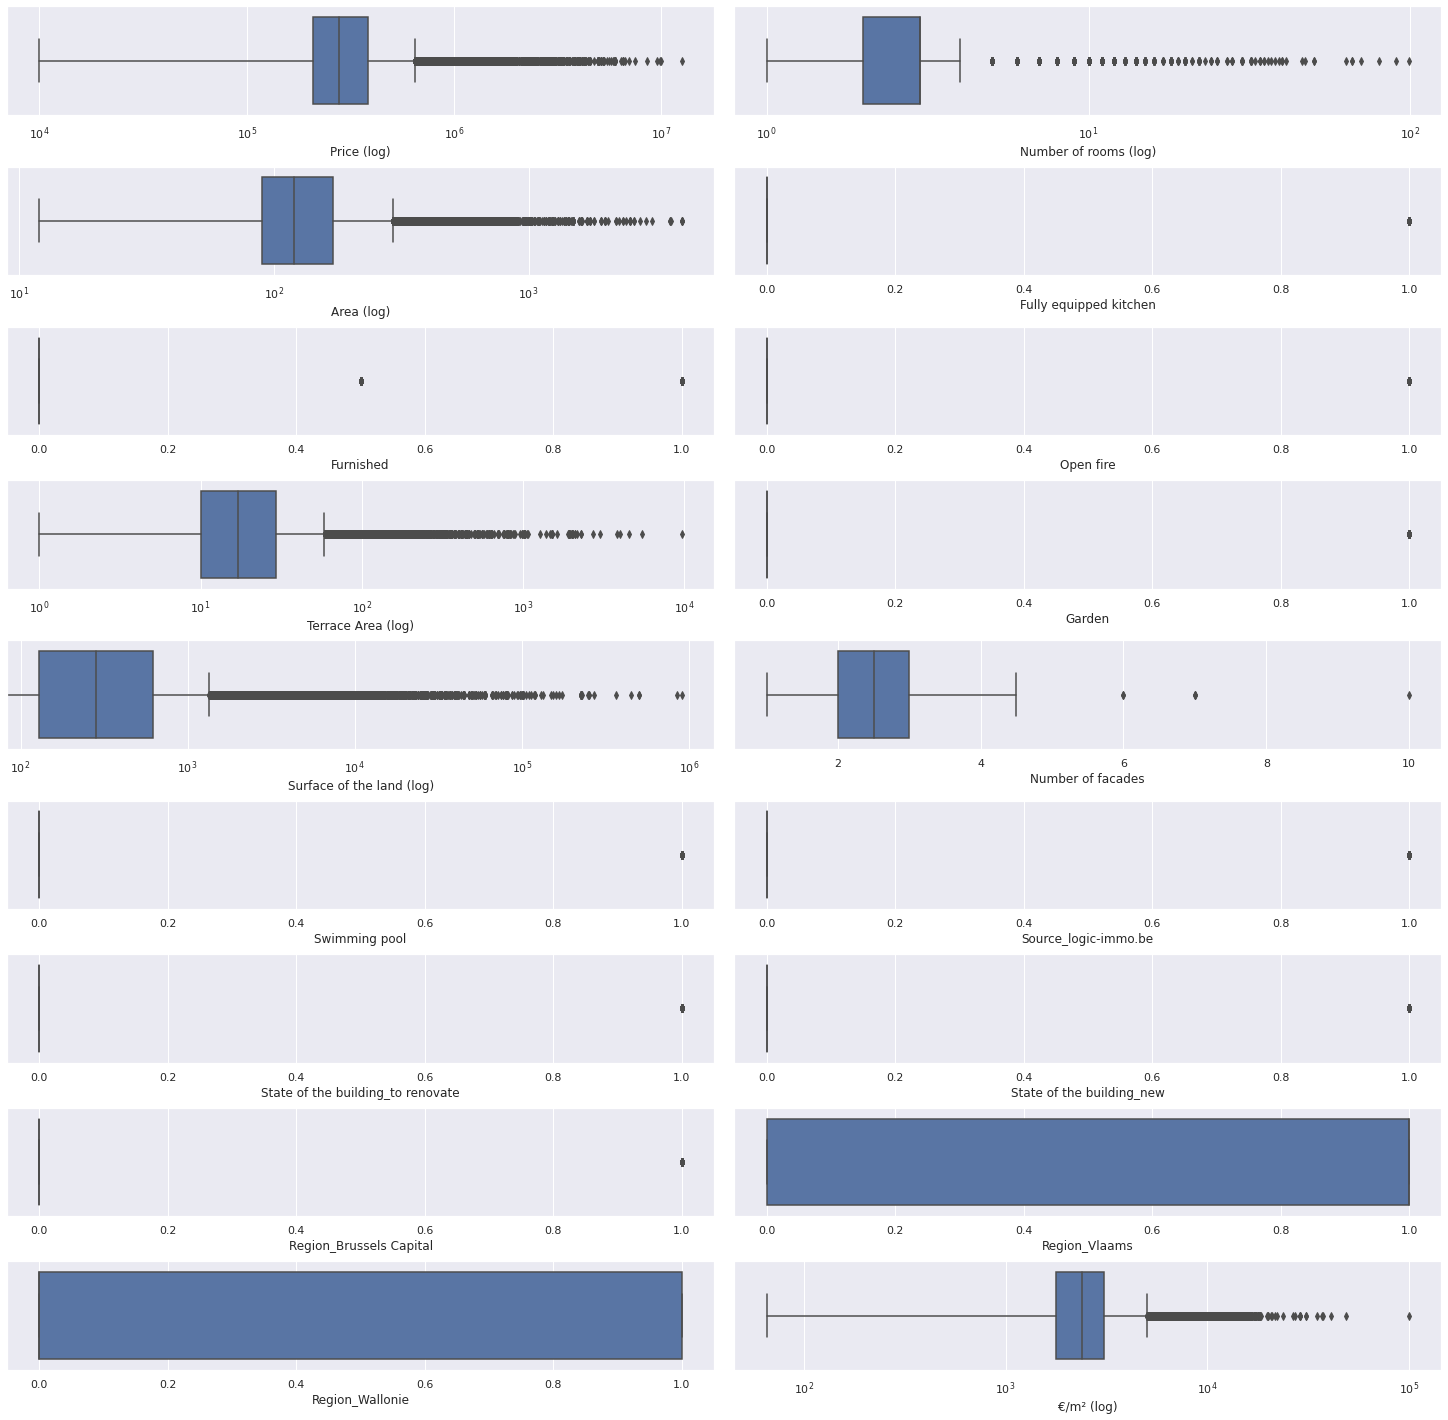

In [ ]:
#@title
fig = plt.figure(figsize=(20,1*data.shape[1]),dpi=72, constrained_layout=True)
gs = fig.add_gridspec(data.shape[1]//2+data.shape[1]%2, 2)
axes = list()
vi_data = data.loc[:, (column for column in data.columns if 
                       not column.startswith("Province") and 
                       not column.startswith("Type of property") and
                       column not in ("Locality", "Terrace")
                       )]
for i, column in enumerate(vi_data.columns):
  ax = fig.add_subplot(gs[i//2, i%2])
  axes.append(ax)
  sns.boxplot(data=data, x=column, ax=ax)

  if column in ("Price", "Number of rooms", "Area", "pr_sqm", "Terrace Area", 
                "Surface of the land"):
    if column == "pr_sqm":
      ax.set_xlabel("€/m²")
    ax.set_xscale("log")
    ax.set_xlabel(f"{ax.get_xlabel()} (log)")




### Which variables would you delete and why ?

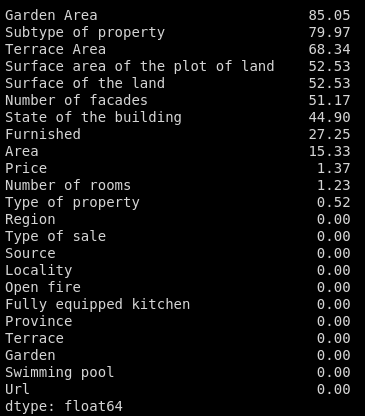

- Garden Area
- Subtype of property

Columns are too empty

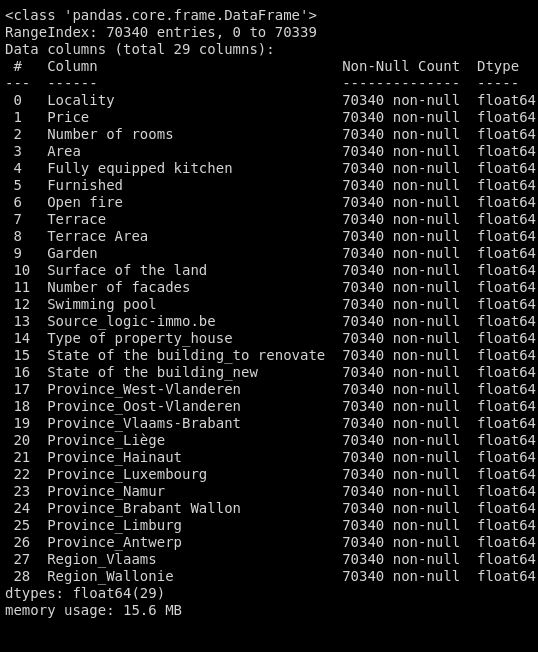

In [ ]:
#@title
locals = pd.read_csv("zipcodes.csv", index_col=0)
analyse = pd.merge(analyse, locals, how="left", left_on="Locality", right_on="zipcode").drop(columns=["zipcode"])
analyse["local"] = analyse["local"].str.lower()

###  In your opinion, which 5 variables are the most important and why?


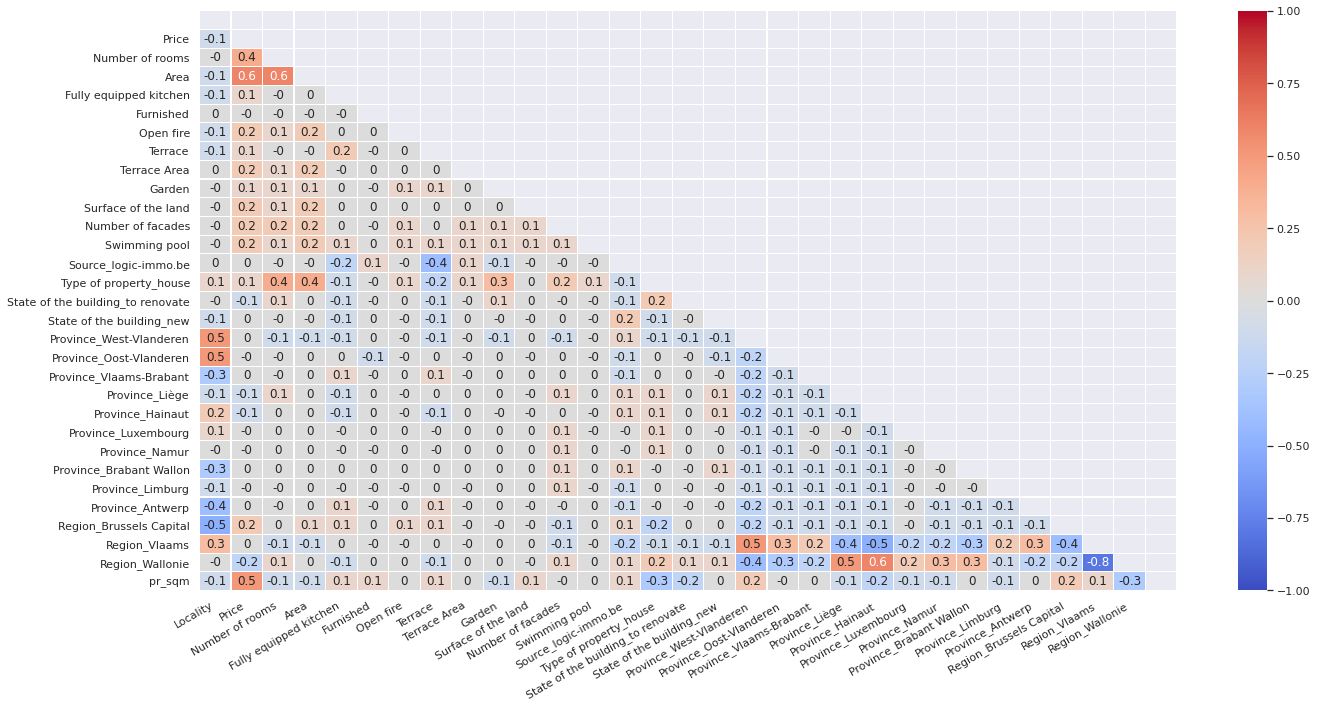

In [ ]:
#@title
upp_mat = np.triu(data.corr())
fig = plt.figure(figsize=(20,10))
ax = sns.heatmap(data=np.round(data.corr(),1), vmin = -1, vmax = +1, mask=upp_mat,
                 annot = True, cmap = 'coolwarm', linewidths=0.1)

ax.set_xticks(ax.get_xticks()[:-1])
ax.set_yticklabels(ax.get_yticklabels()[1:])
ax.set_yticks(ax.get_yticks()[1:])
plt.xticks(rotation=30, ha="right")
plt.tight_layout()

The data with the biggest correlation to the price
0. Area
0. Number of rooms
0. Surface of the land
0. Region Brussel Capital
0. Swimming pool

###  What are the most expensive municipalities in Belgium? (Average price, median price, price per square meter)

In [ ]:
#@title
data = pd.merge(data, locals,how="left", left_on="Locality", right_on="zipcode")
data["Locality"] = data["local"].str.lower()
data.drop(columns="local", inplace=True)
data=data.reset_index()

(array([0]), <a list of 1 Text major ticklabel objects>)

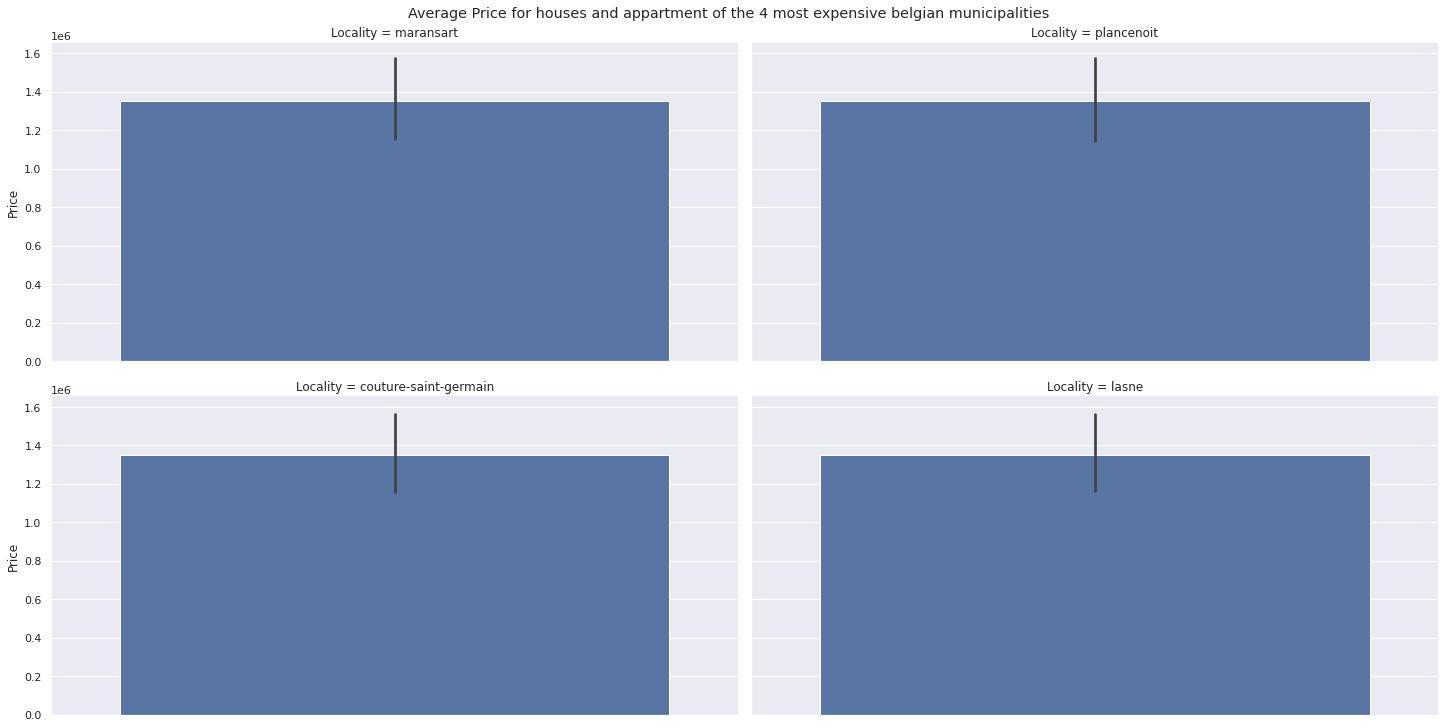

In [ ]:
#@title
zones = data.groupby("Locality")

mdf= zones.mean().sort_values("Price", ascending=False)["Price"].to_frame().reset_index()
idx=mdf.loc[:, "Locality"].values
filter_a = data["Locality"].isin(mdf["Locality"])
sample_idx = zones.count().loc[zones.count()["Price"] >3, "Price"].index

localities = list()
i = 0
for index in idx:
  if index in sample_idx:
    localities.append(index)
  if len(localities) >=4:
    break



filter_sample = data["Locality"].isin(localities)
filter_all = np.logical_and(filter_a, filter_sample)
sns.catplot(data=data.loc[filter_all, ["Locality", "Price"]],
            kind="bar",  
            y="Price",
            col_wrap=2,
            col="Locality",
            estimator=np.mean,
            height=5,
            aspect=2.,
            col_order=localities)
# plt.ylim(bottom=8*10**5, top=2*10**6)
# plt.yscale("log")

plt.suptitle("Average Price for houses and appartment of the 4 most expensive belgian municipalities ", y=1.01)
plt.xticks(rotation=30, ha='right')

Text(0.5, 1.01, 'Median Price for houses and appartment of the 4 most expensive belgian municipalities ')

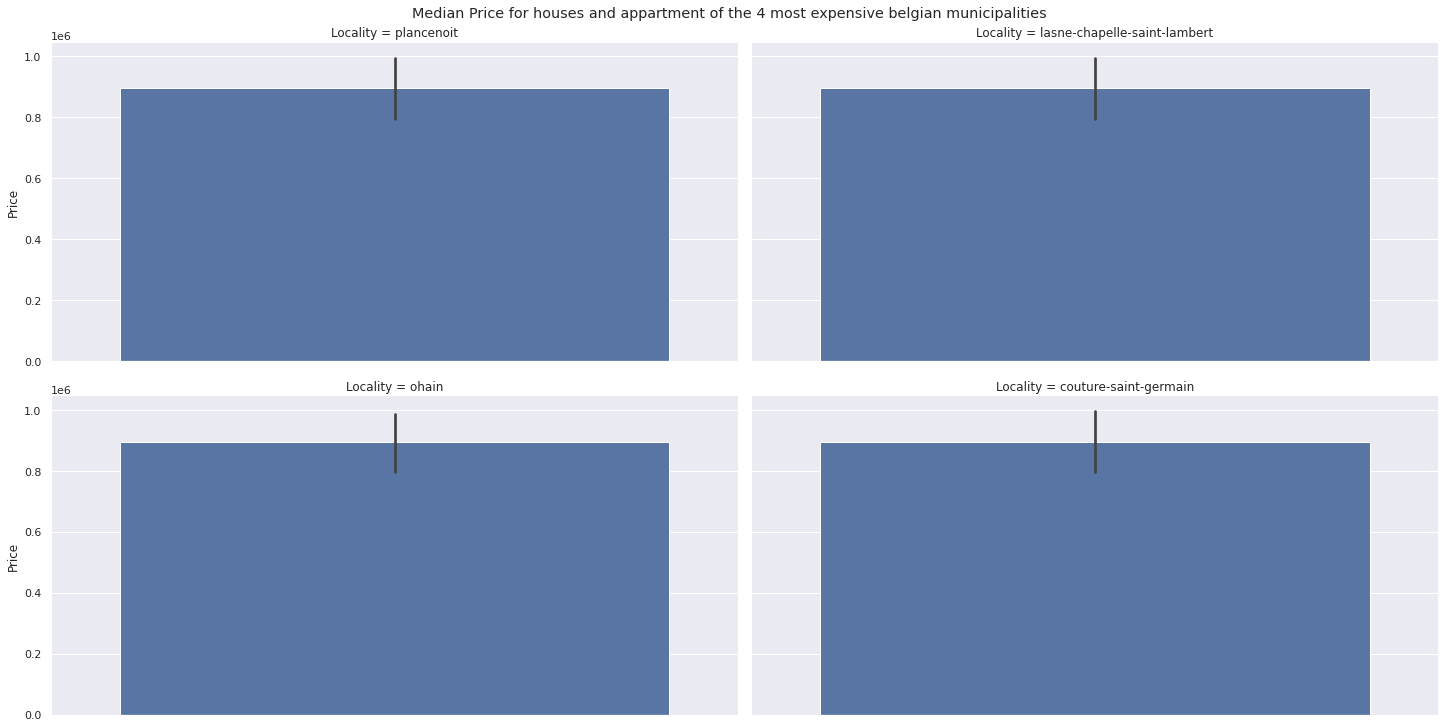

In [ ]:
#@title
mediandf= zones.median().sort_values("Price", ascending=False)["Price"].to_frame().reset_index()
idx=mediandf.loc[:, "Locality"].values

filter_a = data["Locality"].isin(mediandf["Locality"])
sample_idx = zones.count().loc[zones.count()["Price"] >3, "Price"].index

localities = list()
i = 0
for index in idx:
  if index in sample_idx:
    localities.append(index)
  if len(localities) >=4:
    break


filter_sample = data["Locality"].isin(localities)
filter_all = np.logical_and(filter_a, filter_sample)
sns.catplot(data=data.loc[filter_all, ["Locality", "Price"]],
            kind="bar",  
            y="Price",
            col_wrap=2,
            col="Locality",
            estimator=np.median,
            height=5,
            aspect=2.,
            col_order=localities)
plt.suptitle("Median Price for houses and appartment of the 4 most expensive belgian municipalities ", y=1.01)

# plt.ylim(bottom=4*10**5, top=1.1*10**6)
# plt.yscale("log")
# plt.xticks(rotation=30, ha='right')

Text(0.5, 1.01, 'Price per square meter for houses and appartment of the most expensive municipalities ')

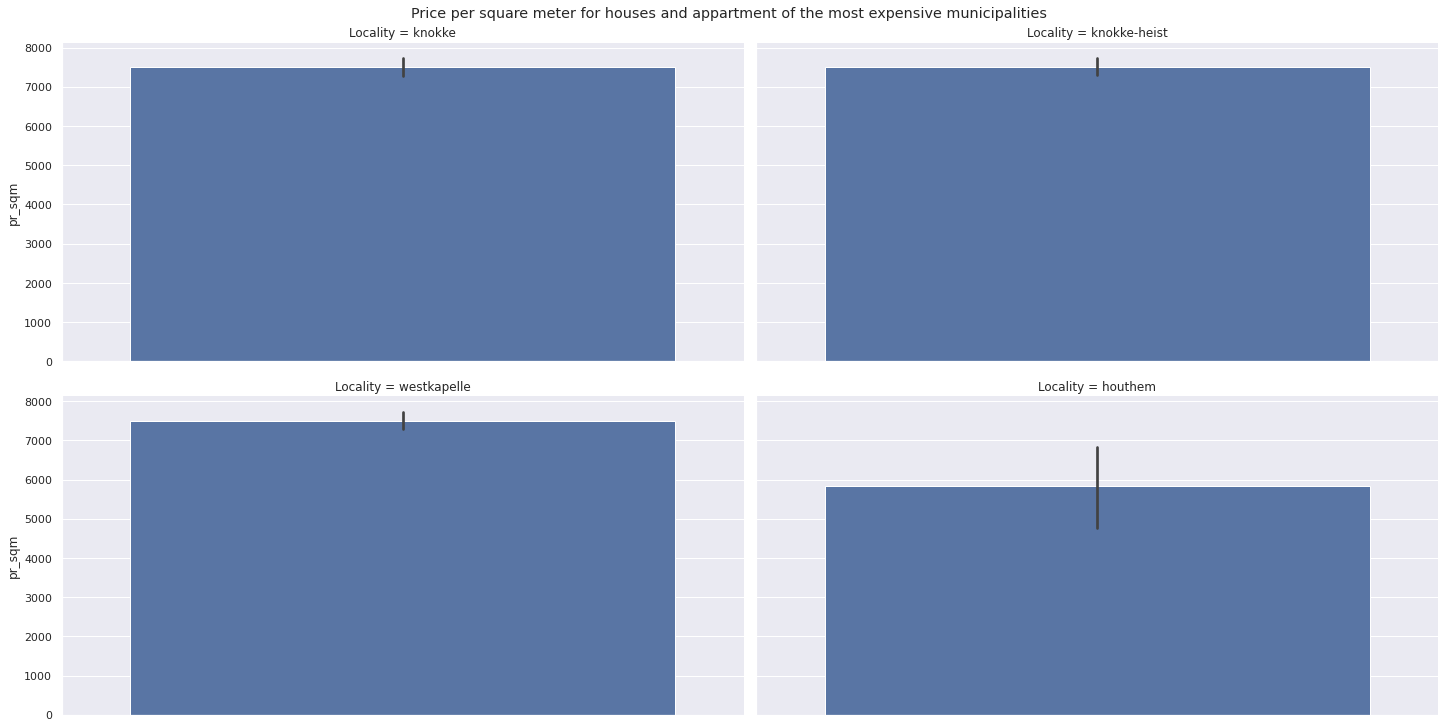

In [ ]:
#@title
mdf= zones.mean().sort_values("pr_sqm", ascending=False)["pr_sqm"].to_frame().reset_index()
idx=mdf.loc[:, "Locality"].values
filter_a = data["Locality"].isin(mdf["Locality"])
sample_idx = zones.count().loc[zones.count()["pr_sqm"] >3, "pr_sqm"].index
localities = list()
i = 0
for index in idx:
  if index in sample_idx:
    localities.append(index)
  if len(localities) >=4:
    break


filter_sample = data["Locality"].isin(localities)
filter_all = np.logical_and(filter_a, filter_sample)
sns.catplot(data=data.loc[filter_all, ["Locality", "pr_sqm"]],
            kind="bar",  
            y="pr_sqm",
            col_wrap=2,
            col="Locality",
            estimator=np.mean,
            height=5,
            aspect=2.,
            col_order=localities)
plt.suptitle("Price per square meter for houses and appartment of the most expensive municipalities ", y=1.01)

# plt.ylim(bottom=6*10**5, top=1.2*10**6)
# plt.yscale("log")
# plt.ylabel("Price per square meter")
# plt.xticks(rotation=30, ha='right')

###  What are the most expensive municipalities in Wallonia? (Average price, median price, price per square meter)

(array([0]), <a list of 1 Text major ticklabel objects>)

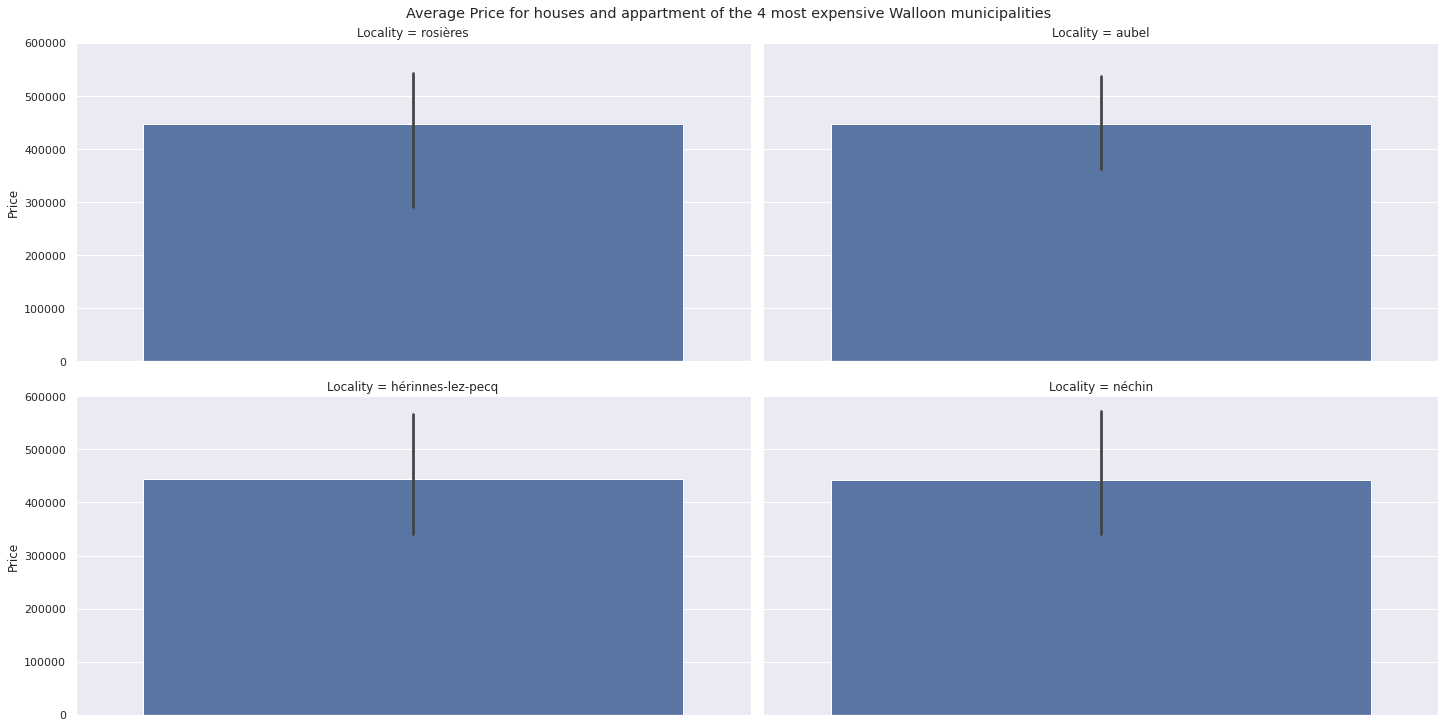

In [ ]:
#@title
zones = data.loc[data["Region_Wallonie"] == 1,:].groupby("Locality")

mdf= zones.mean().sort_values("Price", ascending=False)["Price"].to_frame().reset_index()
idx=mdf.loc[data["Region_Wallonie"] == 1, "Locality"].values
filter_a = data["Locality"].isin(mdf["Locality"])
sample_idx = zones.count().loc[zones.count()["Price"] >3, "Price"].index

localities = list()
i = 0
for index in idx:
  if index in sample_idx:
    localities.append(index)
  if len(localities) >=4:
    break



filter_sample = data["Locality"].isin(localities)
filter_all = np.logical_and(filter_a, filter_sample)
filter_all = np.logical_and(filter_all, data["Region_Wallonie"]==1)
sns.catplot(data=data.loc[filter_all, ["Locality", "Price"]],
            kind="bar",  
            y="Price",
            col_wrap=2,
            col="Locality",
            estimator=np.mean,
            height=5,
            aspect=2.,
            col_order=localities)
# plt.ylim(bottom=8*10**5, top=2*10**6)
# plt.yscale("log")

plt.suptitle("Average Price for houses and appartment of the 4 most expensive Walloon municipalities ", y=1.01)
plt.xticks(rotation=30, ha='right')

Text(0.5, 1.01, 'Median Price for houses and appartment of the most expensive Walloon municipalities ')

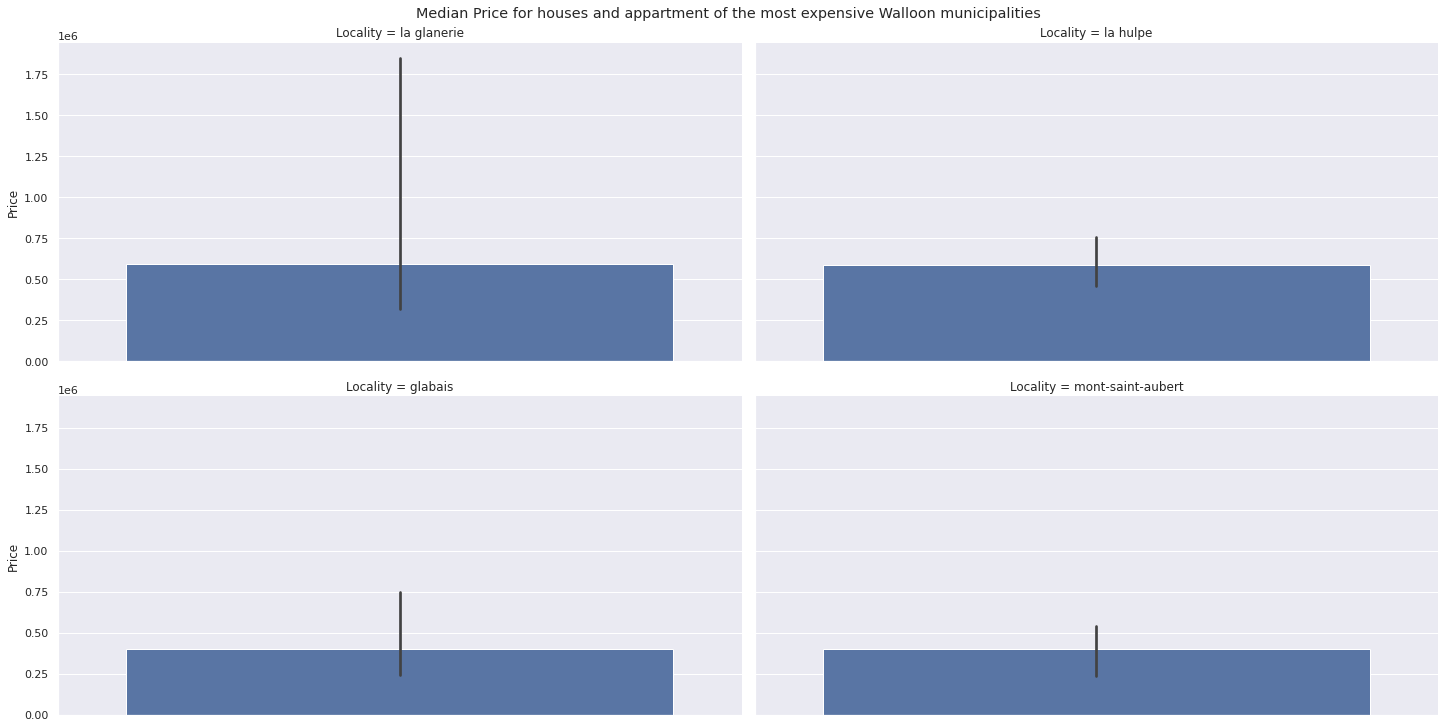

In [ ]:
#@title
mediandf= zones.median().sort_values("Price", ascending=False)["Price"].to_frame().reset_index()
idx=mediandf.loc[data["Region_Wallonie"] == 1, "Locality"].values

filter_a = data["Locality"].isin(mediandf["Locality"])
sample_idx = zones.count().loc[zones.count()["Price"] >3, "Price"].index

localities = list()
i = 0
for index in idx:
  if index in sample_idx:
    localities.append(index)
  if len(localities) >=4:
    break


filter_sample = data["Locality"].isin(localities)
filter_all = np.logical_and(filter_a, filter_sample)
filter_all = np.logical_and(filter_all, data["Region_Wallonie"]==1)
sns.catplot(data=data.loc[filter_all, ["Locality", "Price"]],
            kind="bar",  
            y="Price",
            col_wrap=2,
            col="Locality",
            estimator=np.median,
            height=5,
            aspect=2.,
            col_order=localities)
plt.suptitle("Median Price for houses and appartment of the most expensive Walloon municipalities ", y=1.01)

# plt.ylim(bottom=4*10**5, top=1.1*10**6)
# plt.yscale("log")
# plt.xticks(rotation=30, ha='right')

Text(0.5, 1.01, 'Price per square meter for houses and appartment of the most expensive Walloon municipalities ')

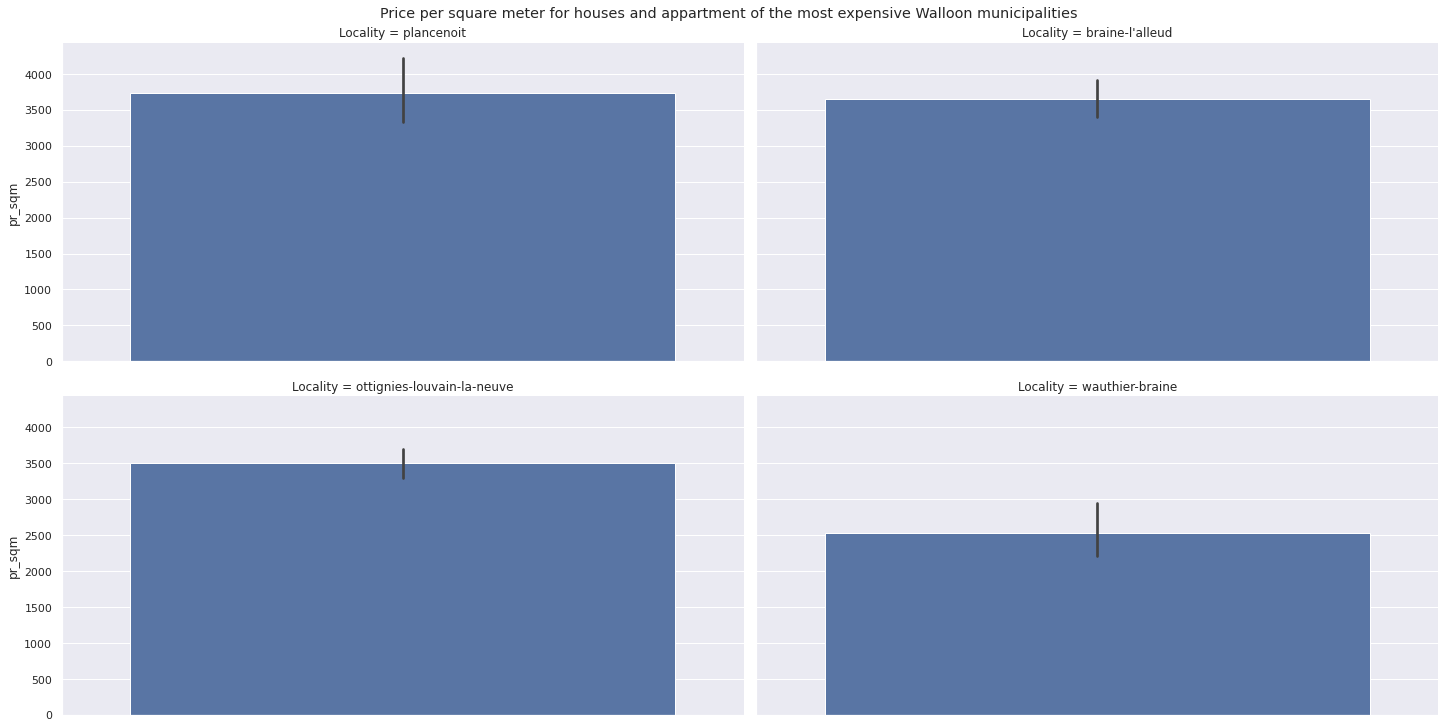

In [ ]:
#@title
mdf= zones.mean().sort_values("pr_sqm", ascending=False)["pr_sqm"].to_frame().reset_index()
idx=mdf.loc[data["Region_Wallonie"] == 1, "Locality"].values
filter_a = data["Locality"].isin(mdf["Locality"])
sample_idx = zones.count().loc[zones.count()["pr_sqm"] >3, "pr_sqm"].index
localities = list()
i = 0
for index in idx:
  if index in sample_idx:
    localities.append(index)
  if len(localities) >=4:
    break


filter_sample = data["Locality"].isin(localities)
filter_all = np.logical_and(filter_a, filter_sample)
filter_all = np.logical_and(filter_all, data["Region_Wallonie"]==1)
sns.catplot(data=data.loc[filter_all, ["Locality", "pr_sqm"]],
            kind="bar",  
            y="pr_sqm",
            col_wrap=2,
            col="Locality",
            estimator=np.mean,
            height=5,
            aspect=2.,
            col_order=localities)
plt.suptitle("Price per square meter for houses and appartment of the most expensive Walloon municipalities ", y=1.01)

# plt.ylim(bottom=6*10**5, top=1.2*10**6)
# plt.yscale("log")
# plt.ylabel("Price per square meter")
# plt.xticks(rotation=30, ha='right')

###  What are the most expensive municipalities in Flanders? (Average price, median price, price per square meter)

(array([0]), <a list of 1 Text major ticklabel objects>)

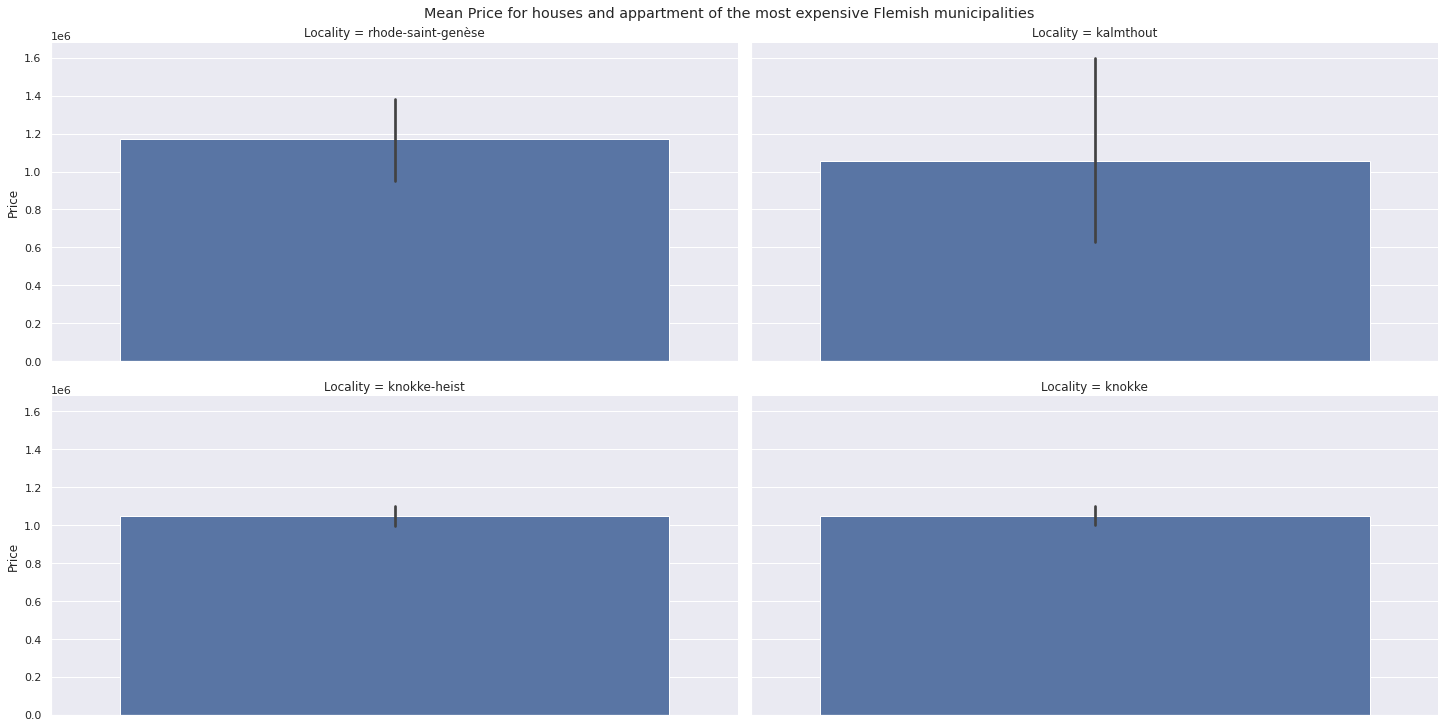

In [ ]:
#@title
zones = data.loc[data["Region_Vlaams"] == 1,:].groupby("Locality")

mdf= zones.mean().sort_values("Price", ascending=False)["Price"].to_frame().reset_index()
idx=mdf.loc[data["Region_Vlaams"] == 1, "Locality"].values
filter_a = data["Locality"].isin(mdf["Locality"])
sample_idx = zones.count().loc[zones.count()["Price"] >3, "Price"].index

localities = list()
i = 0
for index in idx:
  if index in sample_idx:
    localities.append(index)
  if len(localities) >=4:
    break



filter_sample = data["Locality"].isin(localities)
filter_all = np.logical_and(filter_a, filter_sample)
filter_all = np.logical_and(filter_all, data["Region_Vlaams"]==1)
sns.catplot(data=data.loc[filter_all, ["Locality", "Price"]],
            kind="bar",  
            y="Price",
            col_wrap=2,
            col="Locality",
            estimator=np.mean,
            height=5,
            aspect=2.,
            col_order=localities)
# plt.ylim(bottom=8*10**5, top=2*10**6)
# plt.yscale("log")

plt.suptitle("Mean Price for houses and appartment of the most expensive Flemish municipalities ", y=1.01)
plt.xticks(rotation=30, ha='right')

Text(0.5, 1.01, 'Median Price for houses and appartment of the most expensive Flemish municipalities ')

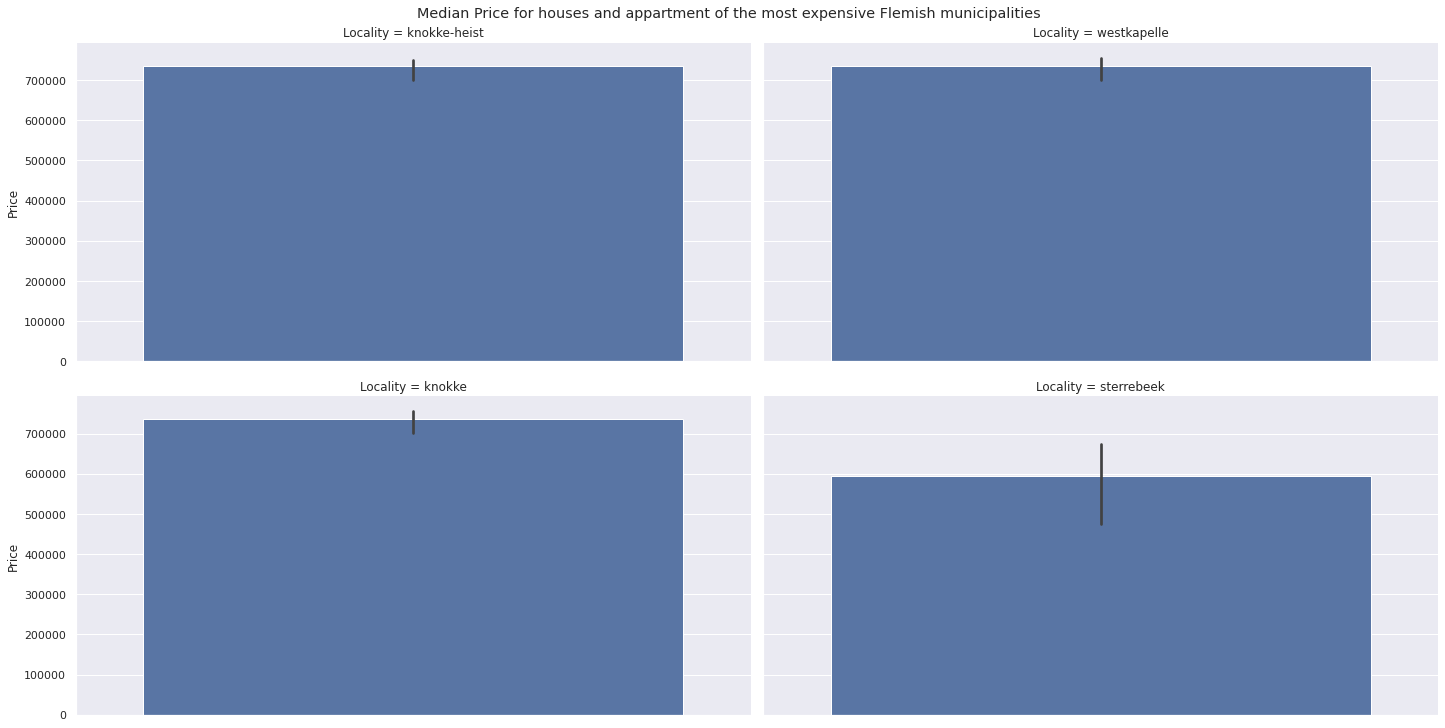

In [ ]:
#@title
mediandf= zones.median().sort_values("Price", ascending=False)["Price"].to_frame().reset_index()
idx=mediandf.loc[data["Region_Vlaams"] == 1, "Locality"].values

filter_a = data["Locality"].isin(mediandf["Locality"])
sample_idx = zones.count().loc[zones.count()["Price"] >3, "Price"].index

localities = list()
i = 0
for index in idx:
  if index in sample_idx:
    localities.append(index)
  if len(localities) >=4:
    break


filter_sample = data["Locality"].isin(localities)
filter_all = np.logical_and(filter_a, filter_sample)
filter_all = np.logical_and(filter_all, data["Region_Vlaams"]==1)
sns.catplot(data=data.loc[filter_all, ["Locality", "Price"]],
            kind="bar",  
            y="Price",
            col_wrap=2,
            col="Locality",
            estimator=np.median,
            height=5,
            aspect=2.,
            col_order=localities)
plt.suptitle("Median Price for houses and appartment of the most expensive Flemish municipalities ", y=1.01)

# plt.ylim(bottom=4*10**5, top=1.1*10**6)
# plt.yscale("log")
# plt.xticks(rotation=30, ha='right')

Text(0.5, 1.01, 'Price per square meter for houses and appartment of the most expensive Flemish municipalities ')

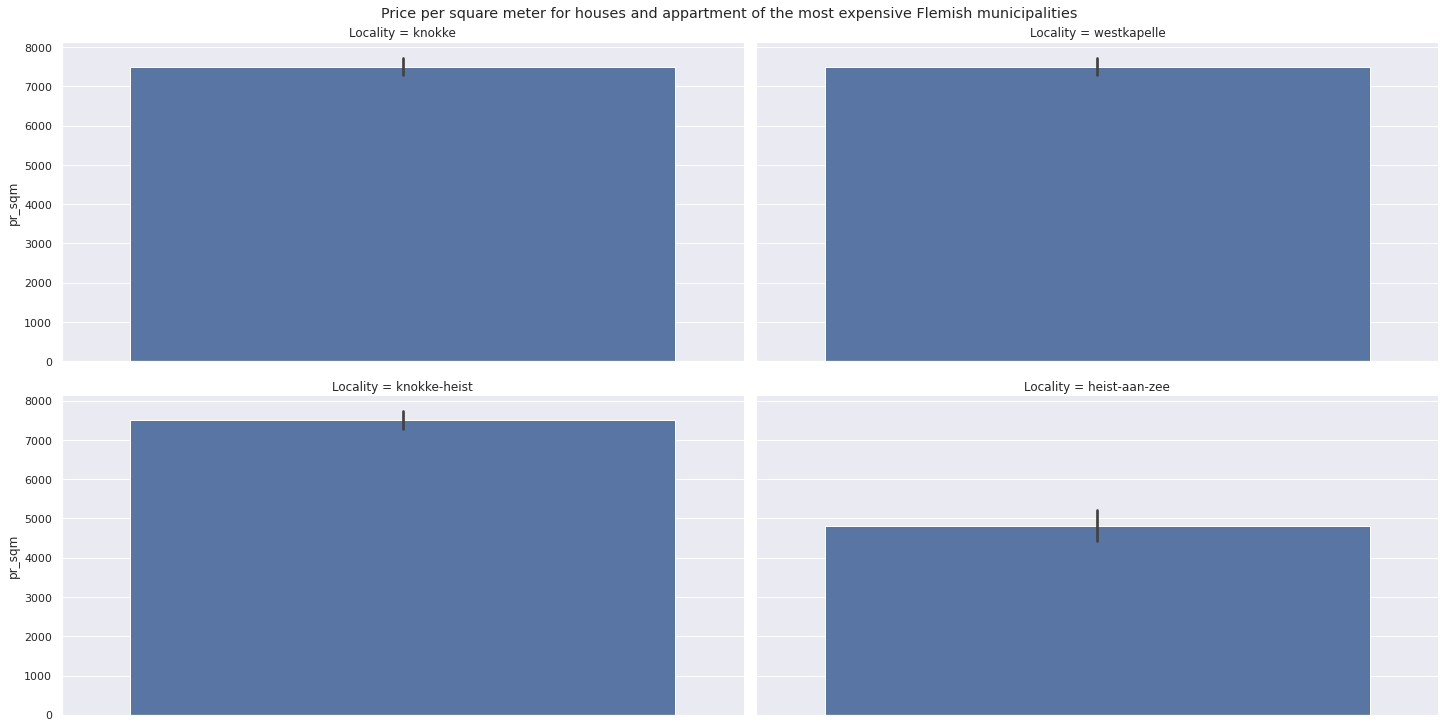

In [ ]:
#@title
mdf= zones.mean().sort_values("pr_sqm", ascending=False)["pr_sqm"].to_frame().reset_index()
idx=mdf.loc[data["Region_Vlaams"] == 1, "Locality"].values
filter_a = data["Locality"].isin(mdf["Locality"])
sample_idx = zones.count().loc[zones.count()["pr_sqm"] >3, "pr_sqm"].index
localities = list()
i = 0
for index in idx:
  if index in sample_idx:
    localities.append(index)
  if len(localities) >=4:
    break


filter_sample = data["Locality"].isin(localities)
filter_all = np.logical_and(filter_a, filter_sample)
filter_all = np.logical_and(filter_all, data["Region_Vlaams"]==1)
sns.catplot(data=data.loc[filter_all, ["Locality", "pr_sqm"]],
            kind="bar",  
            y="pr_sqm",
            col_wrap=2,
            col="Locality",
            estimator=np.mean,
            height=5,
            aspect=2.,
            col_order=localities)
plt.suptitle("Price per square meter for houses and appartment of the most expensive Flemish municipalities ", y=1.01)

# plt.ylim(bottom=6*10**5, top=1.2*10**6)
# plt.yscale("log")
# plt.ylabel("Price per square meter")
# plt.xticks(rotation=30, ha='right')

###  What are the less expensive municipalities in Belgium? (Average price, median price, price per square meter)

(array([0]), <a list of 1 Text major ticklabel objects>)

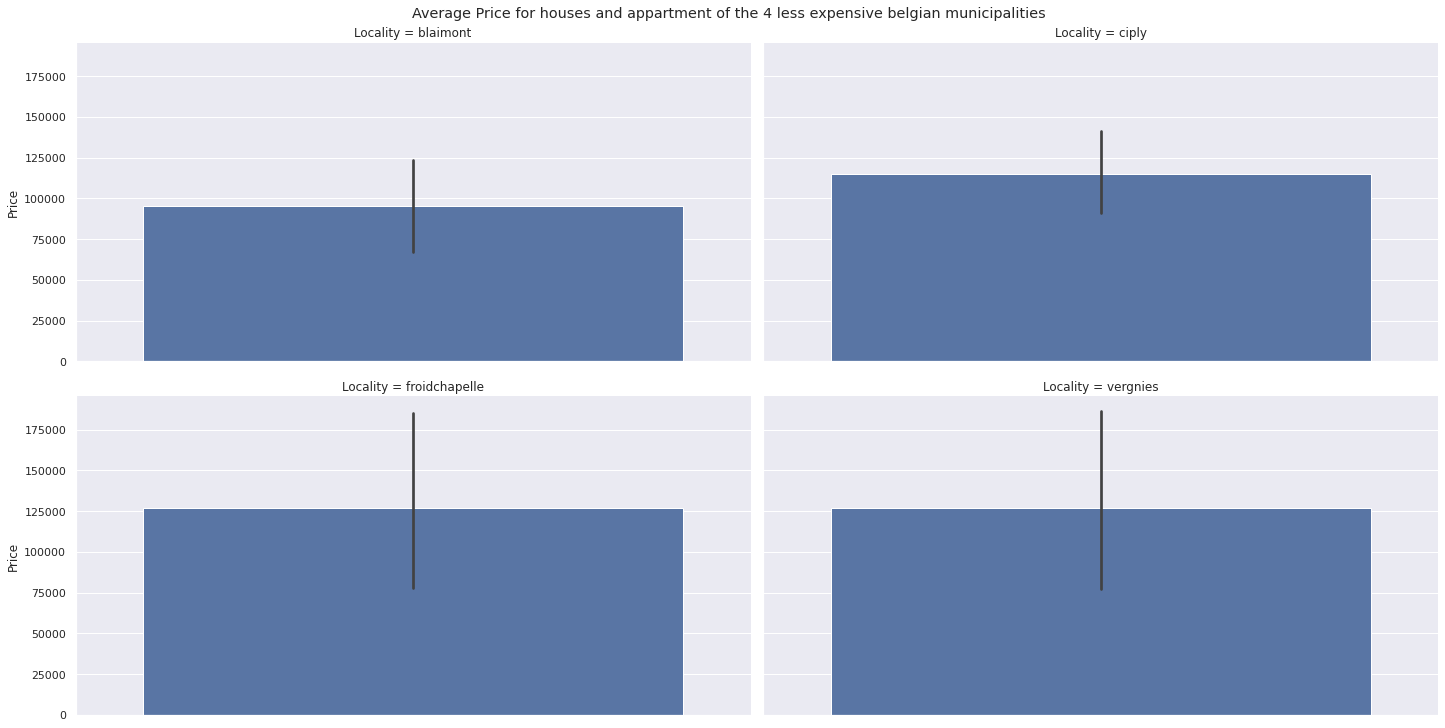

In [ ]:
#@title
zones = data.groupby("Locality")

mdf= zones.mean().sort_values("Price", ascending=True)["Price"].to_frame().reset_index()
idx=mdf.loc[:, "Locality"].values
filter_a = data["Locality"].isin(mdf["Locality"])
sample_idx = zones.count().loc[zones.count()["Price"] >3, "Price"].index

localities = list()
i = 0
for index in idx:
  if index in sample_idx:
    localities.append(index)
  if len(localities) >=4:
    break



filter_sample = data["Locality"].isin(localities)
filter_all = np.logical_and(filter_a, filter_sample)
sns.catplot(data=data.loc[filter_all, ["Locality", "Price"]],
            kind="bar",  
            y="Price",
            col_wrap=2,
            col="Locality",
            estimator=np.mean,
            height=5,
            aspect=2.,
            col_order=localities)
# plt.ylim(bottom=8*10**5, top=2*10**6)
# plt.yscale("log")

plt.suptitle("Average Price for houses and appartment of the 4 less expensive belgian municipalities ", y=1.01)
plt.xticks(rotation=30, ha='right')

Text(0.5, 1.01, 'Median Price for houses and appartment of the 4 most expensive belgian municipalities ')

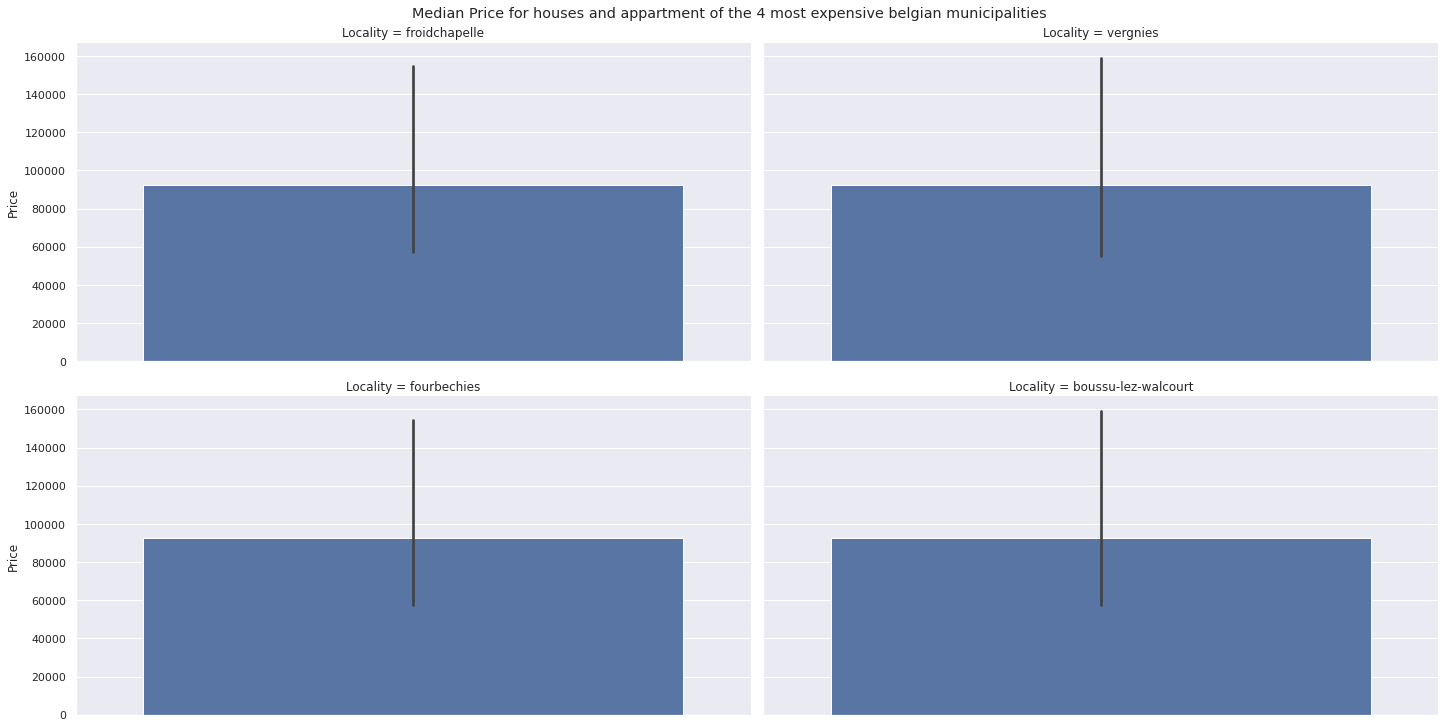

In [ ]:
#@title
mediandf= zones.median().sort_values("Price", ascending=True)["Price"].to_frame().reset_index()
idx=mediandf.loc[:, "Locality"].values

filter_a = data["Locality"].isin(mediandf["Locality"])
sample_idx = zones.count().loc[zones.count()["Price"] >3, "Price"].index

localities = list()
i = 0
for index in idx:
  if index in sample_idx:
    localities.append(index)
  if len(localities) >=4:
    break


filter_sample = data["Locality"].isin(localities)
filter_all = np.logical_and(filter_a, filter_sample)
sns.catplot(data=data.loc[filter_all, ["Locality", "Price"]],
            kind="bar",  
            y="Price",
            col_wrap=2,
            col="Locality",
            estimator=np.median,
            height=5,
            aspect=2.,
            col_order=localities)
plt.suptitle("Median Price for houses and appartment of the 4 most expensive belgian municipalities ", y=1.01)

# plt.ylim(bottom=4*10**5, top=1.1*10**6)
# plt.yscale("log")
# plt.xticks(rotation=30, ha='right')

Text(0.5, 1.01, 'Price per square meter for houses and appartment of the less expensive municipalities ')

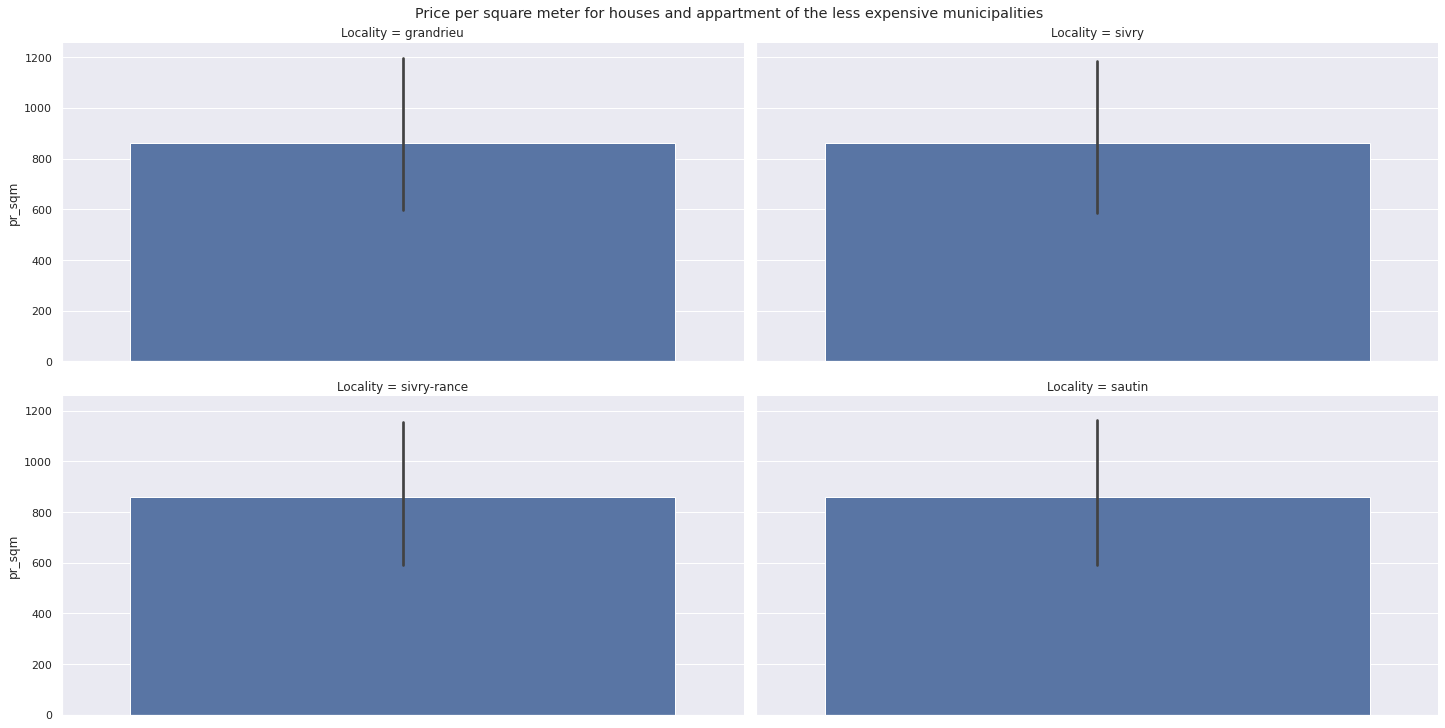

In [ ]:
#@title
mdf= zones.mean().sort_values("pr_sqm", ascending=True)["pr_sqm"].to_frame().reset_index()
idx=mdf.loc[:, "Locality"].values
filter_a = data["Locality"].isin(mdf["Locality"])
sample_idx = zones.count().loc[zones.count()["pr_sqm"] >3, "pr_sqm"].index
localities = list()
i = 0
for index in idx:
  if index in sample_idx:
    localities.append(index)
  if len(localities) >=4:
    break


filter_sample = data["Locality"].isin(localities)
filter_all = np.logical_and(filter_a, filter_sample)
sns.catplot(data=data.loc[filter_all, ["Locality", "pr_sqm"]],
            kind="bar",  
            y="pr_sqm",
            col_wrap=2,
            col="Locality",
            estimator=np.mean,
            height=5,
            aspect=2.,
            col_order=localities)
plt.suptitle("Price per square meter for houses and appartment of the less expensive municipalities ", y=1.01)

# plt.ylim(bottom=6*10**5, top=1.2*10**6)
# plt.yscale("log")
# plt.ylabel("Price per square meter")
# plt.xticks(rotation=30, ha='right')

###  What are the less expensive municipalities in Wallonia? (Average price, median price, price per square meter)

(array([0]), <a list of 1 Text major ticklabel objects>)

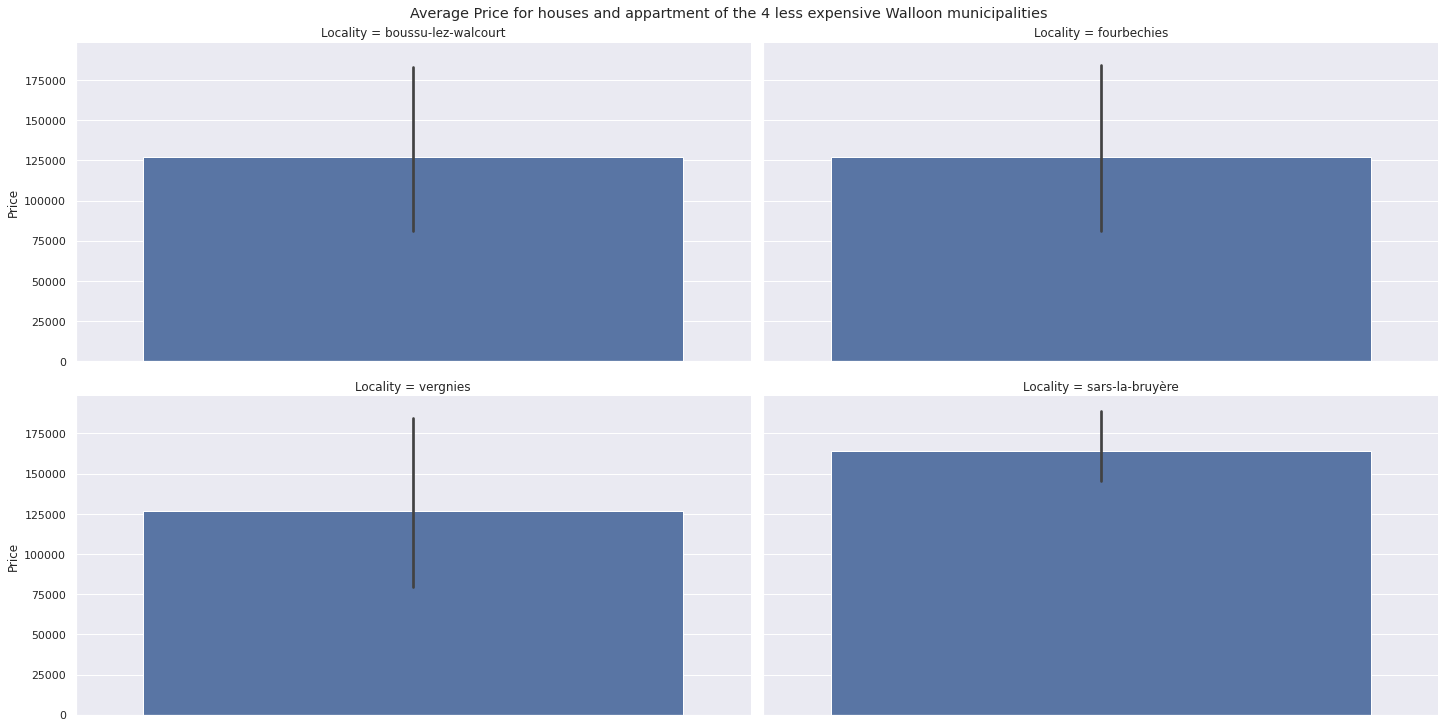

In [ ]:
#@title
zones = data.loc[data["Region_Wallonie"] == 1,:].groupby("Locality")

mdf= zones.mean().sort_values("Price", ascending=True)["Price"].to_frame().reset_index()
idx=mdf.loc[data["Region_Wallonie"] == 1, "Locality"].values
filter_a = data["Locality"].isin(mdf["Locality"])
sample_idx = zones.count().loc[zones.count()["Price"] >3, "Price"].index

localities = list()
i = 0
for index in idx:
  if index in sample_idx:
    localities.append(index)
  if len(localities) >=4:
    break



filter_sample = data["Locality"].isin(localities)
filter_all = np.logical_and(filter_a, filter_sample)
filter_all = np.logical_and(filter_all, data["Region_Wallonie"]==1)
sns.catplot(data=data.loc[filter_all, ["Locality", "Price"]],
            kind="bar",  
            y="Price",
            col_wrap=2,
            col="Locality",
            estimator=np.mean,
            height=5,
            aspect=2.,
            col_order=localities)
# plt.ylim(bottom=8*10**5, top=2*10**6)
# plt.yscale("log")

plt.suptitle("Average Price for houses and appartment of the 4 less expensive Walloon municipalities ", y=1.01)
plt.xticks(rotation=30, ha='right')

Text(0.5, 1.01, 'Median Price for houses and appartment of the most expensive Walloon municipalities ')

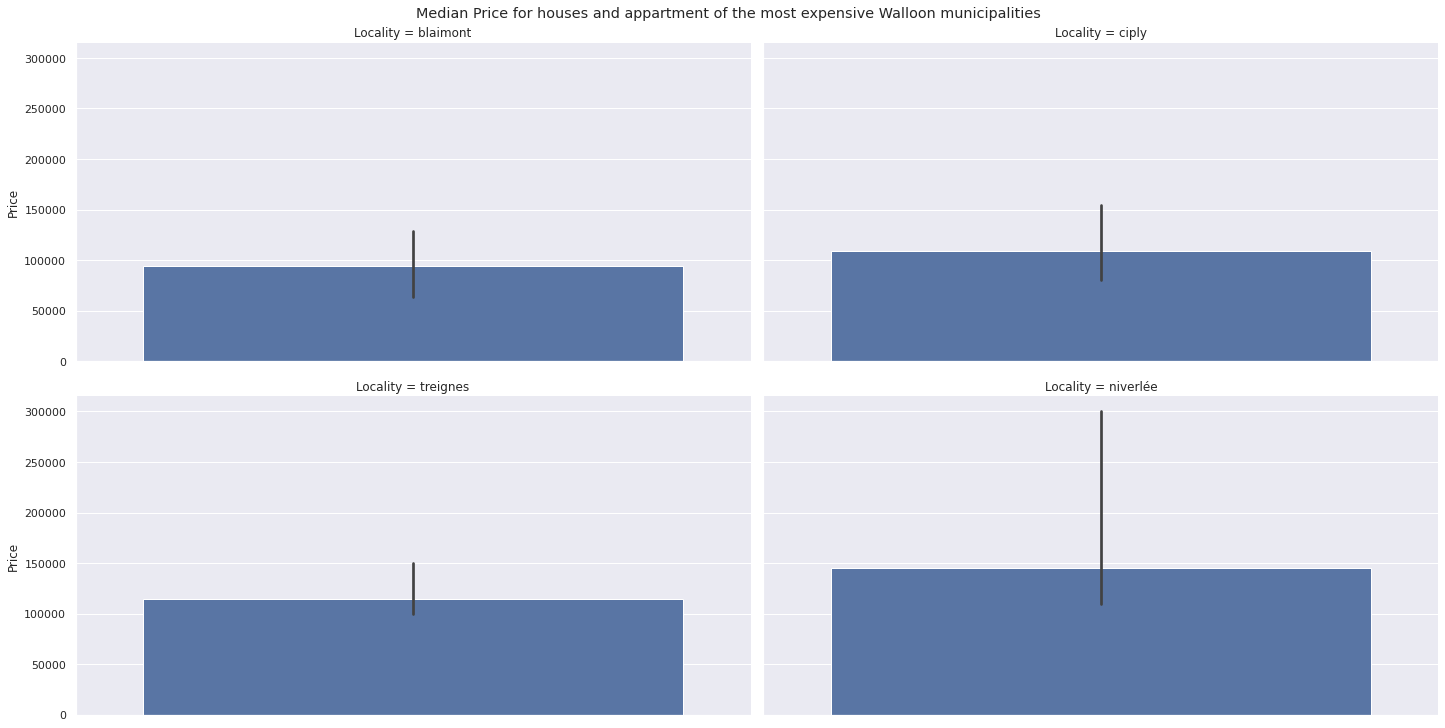

In [ ]:
#@title
mediandf= zones.median().sort_values("Price", ascending=True)["Price"].to_frame().reset_index()
idx=mediandf.loc[data["Region_Wallonie"] == 1, "Locality"].values

filter_a = data["Locality"].isin(mediandf["Locality"])
sample_idx = zones.count().loc[zones.count()["Price"] >3, "Price"].index

localities = list()
i = 0
for index in idx:
  if index in sample_idx:
    localities.append(index)
  if len(localities) >=4:
    break


filter_sample = data["Locality"].isin(localities)
filter_all = np.logical_and(filter_a, filter_sample)
filter_all = np.logical_and(filter_all, data["Region_Wallonie"]==1)
sns.catplot(data=data.loc[filter_all, ["Locality", "Price"]],
            kind="bar",  
            y="Price",
            col_wrap=2,
            col="Locality",
            estimator=np.median,
            height=5,
            aspect=2.,
            col_order=localities)
plt.suptitle("Median Price for houses and appartment of the most expensive Walloon municipalities ", y=1.01)

# plt.ylim(bottom=4*10**5, top=1.1*10**6)
# plt.yscale("log")
# plt.xticks(rotation=30, ha='right')

Text(0.5, 1.01, 'Price per square meter for houses and appartment of the most expensive Walloon municipalities ')

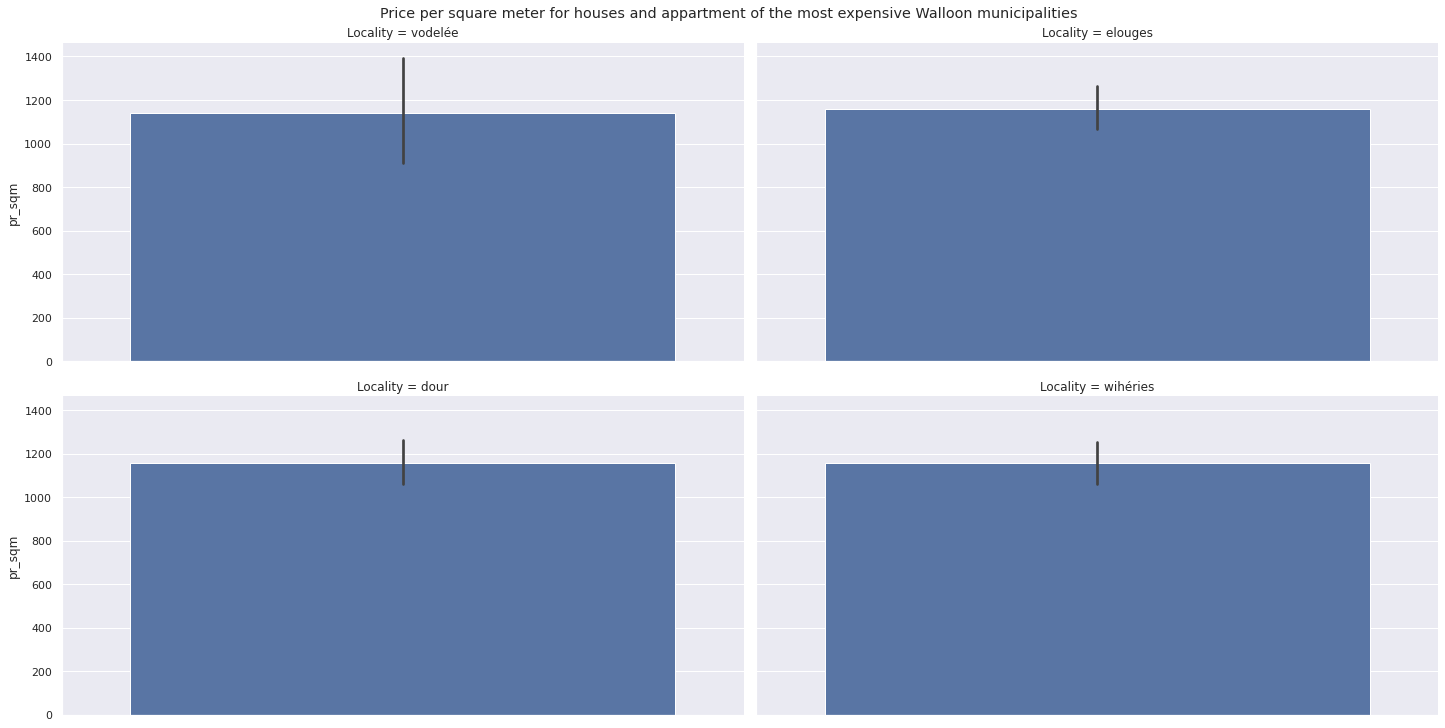

In [ ]:
#@title
mdf= zones.mean().sort_values("pr_sqm", ascending=True)["pr_sqm"].to_frame().reset_index()
idx=mdf.loc[data["Region_Wallonie"] == 1, "Locality"].values
filter_a = data["Locality"].isin(mdf["Locality"])
sample_idx = zones.count().loc[zones.count()["pr_sqm"] >3, "pr_sqm"].index
localities = list()
i = 0
for index in idx:
  if index in sample_idx:
    localities.append(index)
  if len(localities) >=4:
    break


filter_sample = data["Locality"].isin(localities)
filter_all = np.logical_and(filter_a, filter_sample)
filter_all = np.logical_and(filter_all, data["Region_Wallonie"]==1)
sns.catplot(data=data.loc[filter_all, ["Locality", "pr_sqm"]],
            kind="bar",  
            y="pr_sqm",
            col_wrap=2,
            col="Locality",
            estimator=np.mean,
            height=5,
            aspect=2.,
            col_order=localities)
plt.suptitle("Price per square meter for houses and appartment of the most expensive Walloon municipalities ", y=1.01)

# plt.ylim(bottom=6*10**5, top=1.2*10**6)
# plt.yscale("log")
# plt.ylabel("Price per square meter")
# plt.xticks(rotation=30, ha='right')

###  What are the less expensive municipalities in Flanders? (Average price, median price, price per square meter)

(array([0]), <a list of 1 Text major ticklabel objects>)

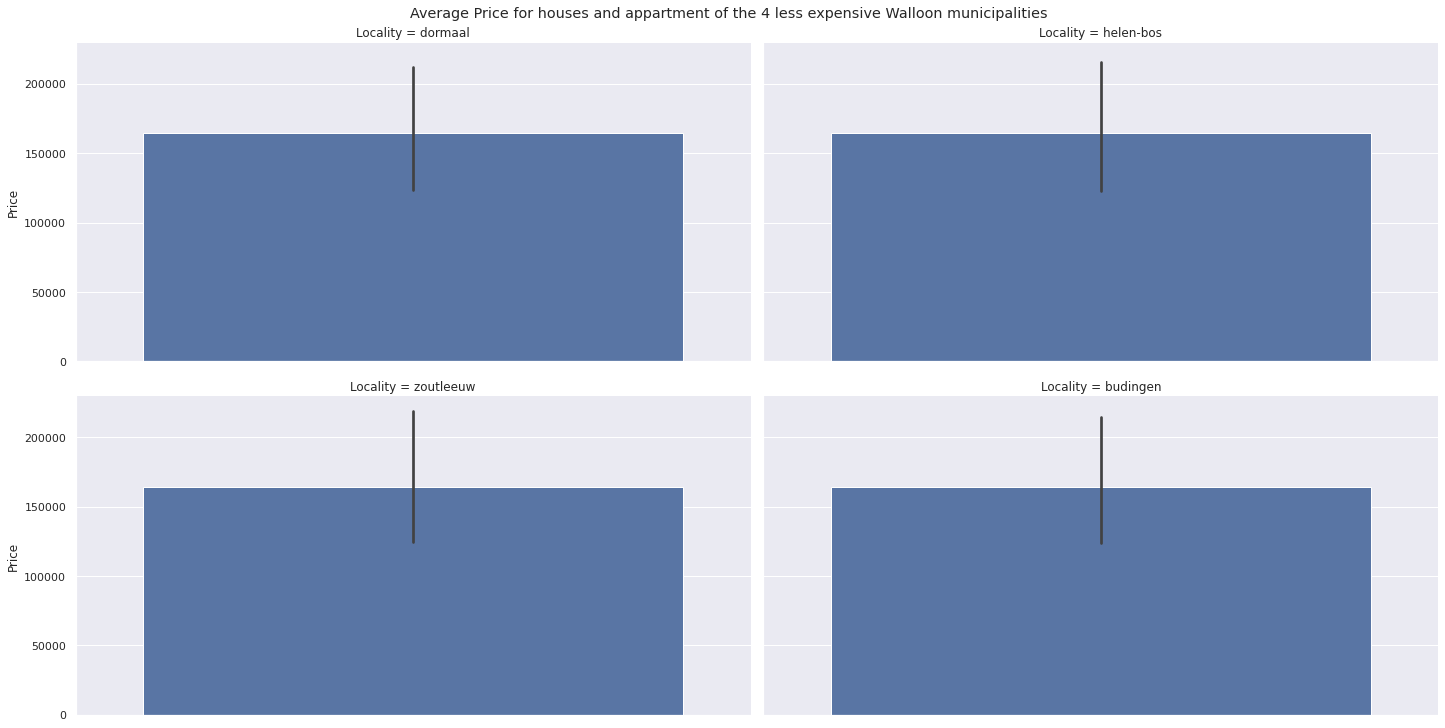

In [ ]:
#@title
zones = data.loc[data["Region_Vlaams"] == 1,:].groupby("Locality")

mdf= zones.mean().sort_values("Price", ascending=True)["Price"].to_frame().reset_index()
idx=mdf.loc[data["Region_Vlaams"] == 1, "Locality"].values
filter_a = data["Locality"].isin(mdf["Locality"])
sample_idx = zones.count().loc[zones.count()["Price"] >3, "Price"].index

localities = list()
i = 0
for index in idx:
  if index in sample_idx:
    localities.append(index)
  if len(localities) >=4:
    break



filter_sample = data["Locality"].isin(localities)
filter_all = np.logical_and(filter_a, filter_sample)
filter_all = np.logical_and(filter_all, data["Region_Vlaams"]==1)
sns.catplot(data=data.loc[filter_all, ["Locality", "Price"]],
            kind="bar",  
            y="Price",
            col_wrap=2,
            col="Locality",
            estimator=np.mean,
            height=5,
            aspect=2.,
            col_order=localities)
# plt.ylim(bottom=8*10**5, top=2*10**6)
# plt.yscale("log")

plt.suptitle("Average Price for houses and appartment of the 4 less expensive Walloon municipalities ", y=1.01)
plt.xticks(rotation=30, ha='right')

Text(0.5, 1.01, 'Median Price for houses and appartment of the most expensive Walloon municipalities ')

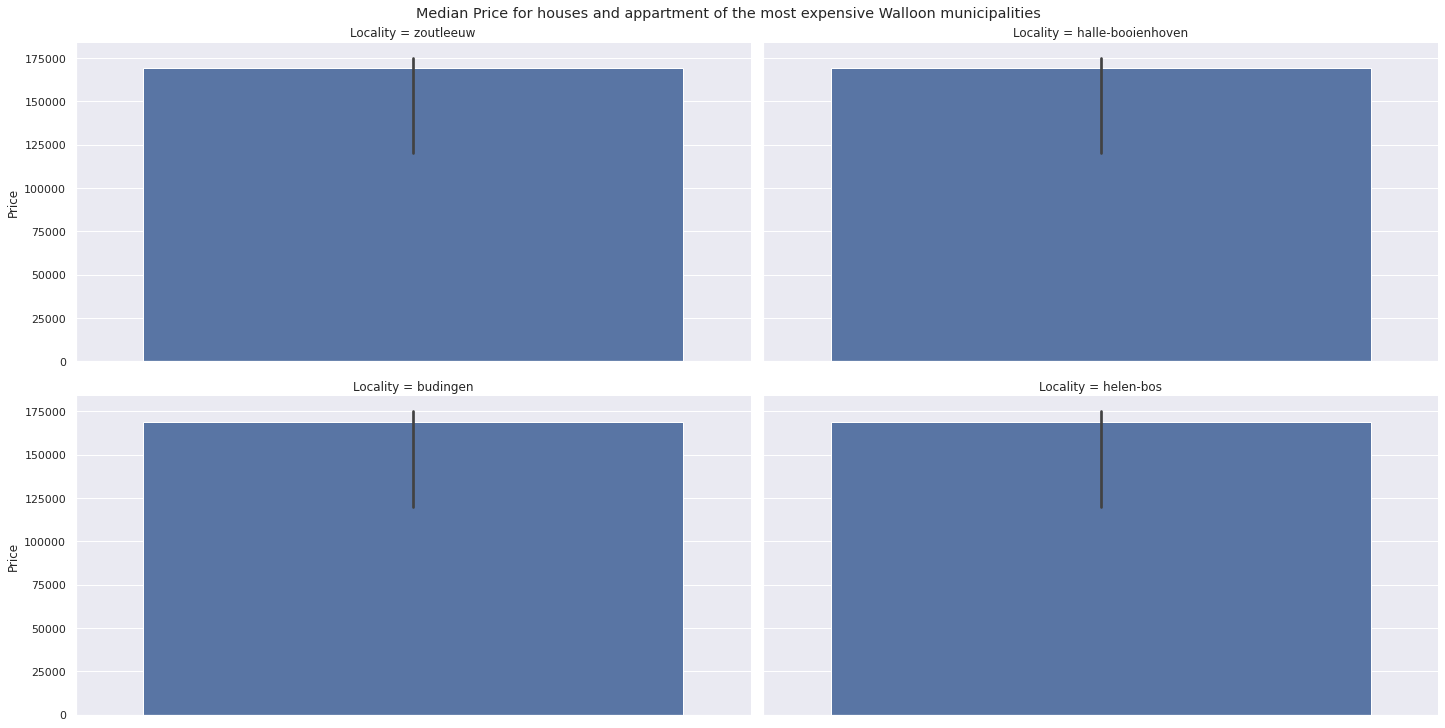

In [ ]:
#@title
mediandf= zones.median().sort_values("Price", ascending=True)["Price"].to_frame().reset_index()
idx=mediandf.loc[data["Region_Vlaams"] == 1, "Locality"].values

filter_a = data["Locality"].isin(mediandf["Locality"])
sample_idx = zones.count().loc[zones.count()["Price"] >3, "Price"].index

localities = list()
i = 0
for index in idx:
  if index in sample_idx:
    localities.append(index)
  if len(localities) >=4:
    break


filter_sample = data["Locality"].isin(localities)
filter_all = np.logical_and(filter_a, filter_sample)
filter_all = np.logical_and(filter_all, data["Region_Vlaams"]==1)
sns.catplot(data=data.loc[filter_all, ["Locality", "Price"]],
            kind="bar",  
            y="Price",
            col_wrap=2,
            col="Locality",
            estimator=np.median,
            height=5,
            aspect=2.,
            col_order=localities)
plt.suptitle("Median Price for houses and appartment of the most expensive Walloon municipalities ", y=1.01)

# plt.ylim(bottom=4*10**5, top=1.1*10**6)
# plt.yscale("log")
# plt.xticks(rotation=30, ha='right')

Text(0.5, 1.01, 'Price per square meter for houses and appartment of the most expensive Walloon municipalities ')

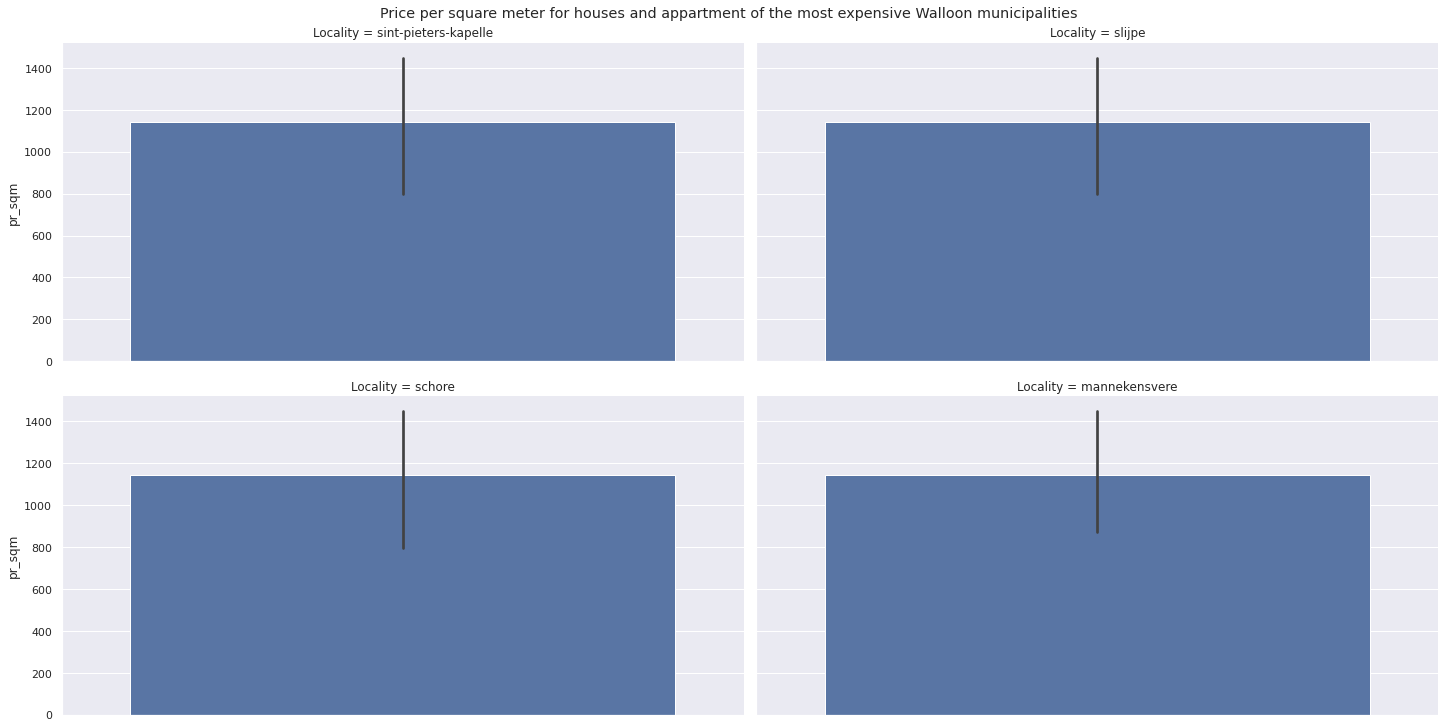

In [ ]:
#@title
mdf= zones.mean().sort_values("pr_sqm", ascending=True)["pr_sqm"].to_frame().reset_index()
idx=mdf.loc[data["Region_Vlaams"] == 1, "Locality"].values
filter_a = data["Locality"].isin(mdf["Locality"])
sample_idx = zones.count().loc[zones.count()["pr_sqm"] >3, "pr_sqm"].index
localities = list()
i = 0
for index in idx:
  if index in sample_idx:
    localities.append(index)
  if len(localities) >=4:
    break


filter_sample = data["Locality"].isin(localities)
filter_all = np.logical_and(filter_a, filter_sample)
filter_all = np.logical_and(filter_all, data["Region_Vlaams"]==1)
sns.catplot(data=data.loc[filter_all, ["Locality", "pr_sqm"]],
            kind="bar",  
            y="pr_sqm",
            col_wrap=2,
            col="Locality",
            estimator=np.mean,
            height=5,
            aspect=2.,
            col_order=localities)
plt.suptitle("Price per square meter for houses and appartment of the most expensive Walloon municipalities ", y=1.01)

# plt.ylim(bottom=6*10**5, top=1.2*10**6)
# plt.yscale("log")
# plt.ylabel("Price per square meter")
# plt.xticks(rotation=30, ha='right')